# GUIA 1

## Ejercico 3 

Utilice las herramientas aprendidas en esta unidad para implementar un sistema que permita identificar una botella que no esta correctamente llena. Las imagenes que se proporcionaran son capturadas con una camara fija, en escala de grises y directamente de la lnea de envasado. Para implementar el sistema debera bastarle una imagen de ejemplo botella.tif (que encontrara en el repositorio). Adicionalmente, se espera que el sistema pueda: 
1. identificar una botella no-llena en cualquier posicion de la imagen. 
2. indicar la posicion de la botella en la imagen (podra ser con un recuadro, informando la posicion relativa entre botellas, la posicion absoluta en pixels, etc). 
3. informar el porcentaje de llenado de la botella no-llena.

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. cargamos la imagen

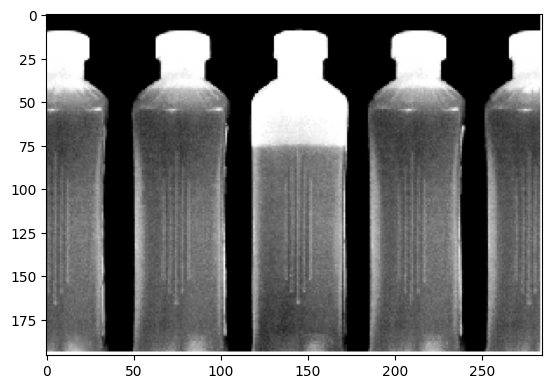

In [26]:
# imagen_path = '../imagenUtils/Imagenes/botellas.tif'
imagen_path = './imagenes/botellas.tif'
imagen = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(imagen, cmap='gray')

Text(0, 0.5, 'intensidad')

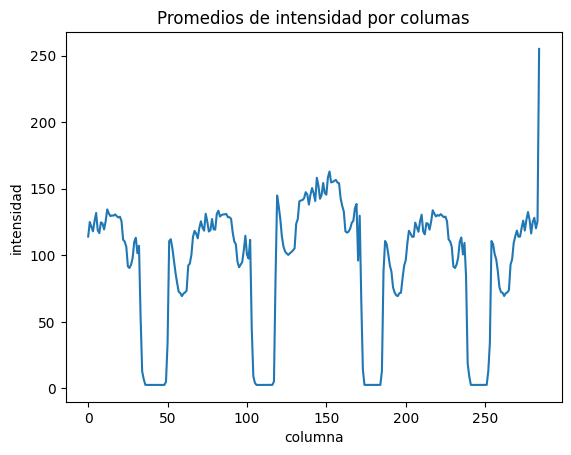

In [27]:
# promedios de intensidad de la imagen
promedio_int_col = imagen.mean(axis=0)
plt.plot(promedio_int_col)
plt.title('Promedios de intensidad por columas')
plt.xlabel('columna')
plt.ylabel('intensidad')


2. obtenemos las pociciones de las botellas

In [28]:
# Detectar donde supera el umbral
umbral = 20
objetos = promedio_int_col > umbral

# Encontrar cambios de False a True (inicio) y True a False (fin)
cambios = np.diff(objetos.astype(int))
picks = np.where(abs(cambios) == 1)[0].tolist()

# si el primero es negativo es porque arranca con un objeto cortado
if cambios[picks[0]] < 0:
    picks.insert(0,0)
    
# si el ultimo es positivo es porque termina con un objeto cortado
if cambios[picks[-1]] > 0:
    picks.append(len(cambios)-1)

botellas =  list(zip(picks[::2], picks[1::2]))
print(botellas)

[(0, 33), (49, 103), (117, 172), (185, 238), (252, 283)]


3. detectar altura de las botellas

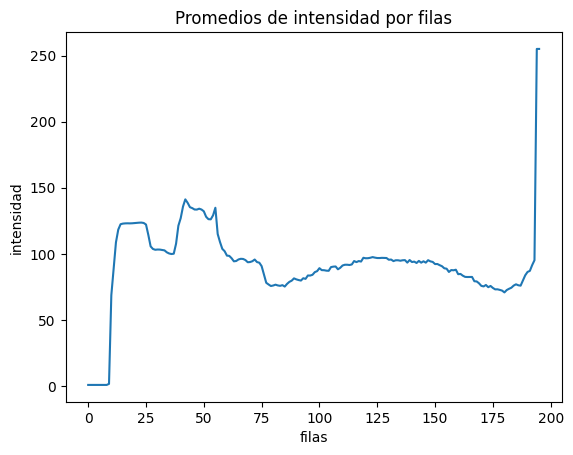

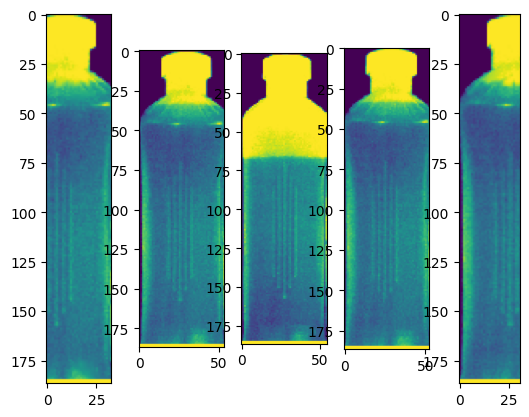

In [29]:
# Calculamos la altura de la botella
promedio_int_fil = imagen.mean(axis=1)
h = np.where(np.diff(promedio_int_fil > umbral) != 0)[0].tolist()
h = h[0]

# graficamos la intencidad promedio de las filas de la imagen
plt.plot(promedio_int_fil)
plt.title('Promedios de intensidad por filas')
plt.xlabel('filas')
plt.ylabel('intensidad')
botellas
# graficamos las botellas individuales
plt.figure()
for i in range(0, len(botellas)):
    plt.subplot(1,5,i+1)
    plt.imshow(imagen[h:, botellas[i][0]:botellas[i][1]])

4. medimos la intencidad promedio de cada botella

La botella le falta un 21.43841427779954% para esta llena


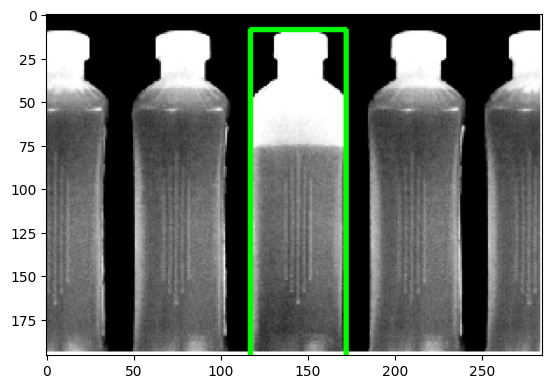

In [30]:
# "eliminamos" el fondo de la imagen
img = imagen.copy()
img[img < 20] = 255
intensidades = [img[h:, ini:fin].mean().item() for ini, fin in botellas]

# tomamos la intencidad maxima como "lleno".
botella_llena = intensidades.index(min(intensidades))
botella_vacia = intensidades.index(max(intensidades))

# dibujamos el rectangulo en la botella vacia
img = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR)
cv2.rectangle(img, (botellas[botella_vacia][0],h), (botellas[botella_vacia][1], imagen.shape[1]), (0,255,0), 2)
plt.imshow(img)

# calculamos que tan llena esta
diff_contenido = intensidades[botella_vacia] - intensidades[botella_llena]
print(f'La botella le falta un {(diff_contenido / intensidades[botella_llena]) * 100}% para esta llena')

# GUIA 4

## Ejercicio 5

El gobierno de la provincia de Misiones lo ha contratado para realizar una aplicacion que sea capaz de detectar zonas deforestadas. Para desarrollar un primer prototipo le han suministrado una imagen satelital (Deforestacion.png) en la que un experto ya delimito el area donde debera existir monte nativo y sobre la cual usted debe trabajar. Se requiere que su aplicacion: 
1. Segmente y resalte en algun tono de rojo el area deforestada. 
2. Calcule el area total (hectareas) de la zona delimitada, el area de la zona que tiene monte y el area de la zona deforestada. 
3. (Opcional) Detecte automaticamente la delimitacion de la zona. 

Ayuda: 
1. Explore todos los canales de los diferentes modelos de color para determinar cual (o que combinacion de ellos) le proporciona mas informacion. 
2. Como su objetivo es la segmentacion de las distintas zonas, piense que herramienta (de las que ya conoce) le permitira lograr zonas mas homogeneas. 
3. Utilice la referencia de la esquina inferior izquierda para computar los tamanos de las regiones.

In [228]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# cargamos la imagen
imagen = cv2.imread('./imagenes/Deforestacion.png')


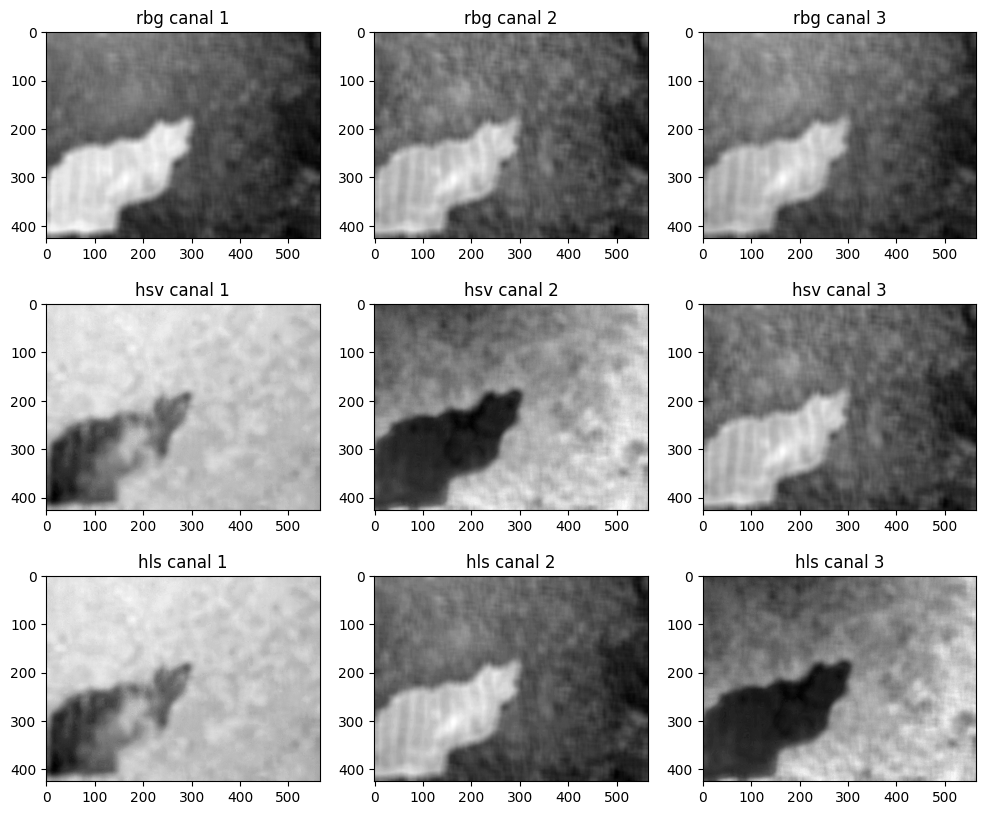

In [229]:
# seleccionamos el area de interes
imagen_roi = cv2.cvtColor(imagen[275:700, 160:725], cv2.COLOR_BGR2RGB)

# Le aplicamos filtro de suavizado
kernel_size=19
kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
kernel /= (kernel_size**2)
imagen_suavizada = cv2.filter2D(imagen_roi,-1,kernel,cv2.BORDER_REPLICATE)

# Cambiamos la representacion del color
imagen_rbg = imagen_suavizada.copy()
imagen_hsv = cv2.cvtColor(imagen_suavizada, cv2.COLOR_RGB2HSV)
imagen_hls = cv2.cvtColor(imagen_suavizada, cv2.COLOR_RGB2HLS)

imgs = {
    'rbg': imagen_rbg, 
    'hsv': imagen_hsv, 
    'hls': imagen_hls
}

# Mostrar canales de color
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# Canales
fig_row = 0
for tittle, img in imgs.items():
    axes[fig_row,0].imshow(img[:,:,0], cmap='gray')
    axes[fig_row,0].set_title(f'{tittle} canal 1')
    axes[fig_row,1].imshow(img[:,:,1], cmap='gray')
    axes[fig_row,1].set_title(f'{tittle} canal 2')
    axes[fig_row,2].imshow(img[:,:,2], cmap='gray')
    axes[fig_row,2].set_title(f'{tittle} canal 3')
    fig_row+=1
plt.show()

La cantidad de pixeles de forestados 41098)
El porcentaje de area desforestada es: 17.115252472670484%
El porcentaje de area desforestada es: 17.115252472670484%


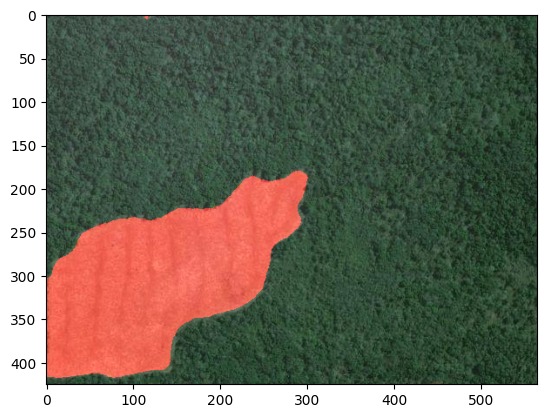

In [233]:
# podemos observar que donde mayor se aprecia mayor contraste entre las distintas zonas es:
# en el canal 1 de la imagen RGB (canal rojo)
imagen_interes = imagen_rbg
canal = 0
umbral = 75

# buscamos la zona de interes
mask = np.zeros(imagen_roi.shape[:2])
mask[imagen_interes[:,:,canal] > umbral] = 1

red = (mask * 150).astype(np.uint8)
black = np.zeros(imagen_roi.shape[:2]).astype(np.uint8)
mask_color = cv2.merge([red, black, black])

resultado = cv2.add(imagen_roi, mask_color)
plt.imshow(resultado)

pixeles_rojos = np.count_nonzero(mask == 1)
pixeles_tot = mask.shape[0] * mask.shape[1]
print(f'La cantidad de pixeles de forestados {pixeles_rojos})')
print(f'El porcentaje de area desforestada es: {(pixeles_rojos/pixeles_tot) * 100}%')
print(f'El porcentaje de area desforestada es: {(pixeles_rojos/pixeles_tot) * 100}%')
